In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_circles
from sklearn.model_selection import GridSearchCV
import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Zadanie 1


Rozważamy klasyfikację binarną z etykietami $y_i \in \{-1, +1\}$.  
Liniowy SVM szuka hiperpłaszczyzny $w^\top x + b = 0$, która maksymalizuje margines między klasami.

Dla miękkiego marginesu minimalizujemy funkcję celu:
$$
\min_{w,b} \;\; \frac{1}{2}\lVert w\rVert^2 
+ C \sum_{i=1}^n \max(0, 1 - y_i (w^\top x_i + b)),
$$
gdzie $C > 0$ równoważy szerokość marginesu i karę za błędy.

W poniższym kodzie rozwiązujemy ten problem w postaci pierwotnej w sposób przybliżony, metodą iteracyjną: kroki aktualizacji $w$ i $b$ dążą do zmniejszenia normy $\lVert w\rVert$ przy jednoczesnym pilnowaniu warunku marginesu $y_i (w^\top x_i + b) \ge 1$. Na końcu rysujemy wyznaczoną hiperpłaszczyznę oraz marginesy.


Dokładność na danych treningowych: 1.000
Wektor wag w: [0.41261814 0.51963808]
Bias b: -0.07


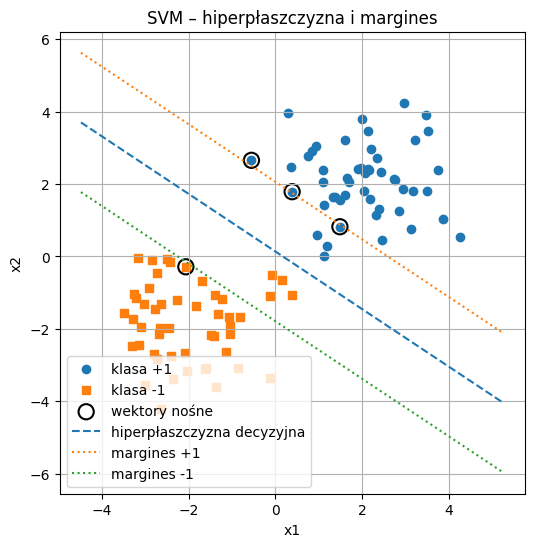

In [10]:
np.random.seed(0)

N = 50

# Klasa +1 wokół (2, 2)
X_pos = np.random.randn(N, 2) + np.array([2, 2])
y_pos = np.ones(N)

# Klasa -1 wokół (-2, -2)
X_neg = np.random.randn(N, 2) + np.array([-2, -2])
y_neg = -np.ones(N)

X = np.vstack([X_pos, X_neg])
y = np.hstack([y_pos, y_neg])



class LinearSVM:
    """
    Prosty liniowy SVM (soft-margin) trenowany metodą
    stochastycznego spadku gradientowego (SGD) po funkcji celu:

        1/2 ||w||^2 + C * sum_i max(0, 1 - y_i (w^T x_i + b))

    Parametry:
    ----------
    learning_rate : float
        Krok uczenia (eta) spadku gradientowego.
    C : float
        Współczynnik kary za błędy
    n_epochs : int
        Liczba epok (pełnych przejść po zbiorze danych).
    """
    def __init__(self, learning_rate=0.001, C=10.0, n_epochs=100):
        self.learning_rate = learning_rate
        self.C = C
        self.n_epochs = n_epochs
        self.w = None
        self.b = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        # Mapowanie etykiet {0,1} -> {-1, +1}, jeśli trzeba
        y = np.where(y <= 0, -1, 1)

        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0.0

        lr = self.learning_rate
        C = self.C

        for epoch in range(self.n_epochs):
            # Prosty SGD: iterujemy po próbkach
            for i in range(n_samples):
                xi = X[i]
                yi = y[i]

                # Sprawdzamy, czy punkt spełnia warunek marginesu:
                condition = yi * (np.dot(xi, self.w) + self.b) >= 1

                if condition:
                    # Prawidłowo sklasyfikowany z zapasem marginesu
                    # Grad w: po 1/2||w||^2 to po prostu w
                    grad_w = self.w
                    grad_b = 0.0
                else:
                    # Punkt w marginesie lub źle sklasyfikowany
                    # Gradient (w, b) po hinge-loss + regularyzacja:
                    # d/dw: w - C * y_i * x_i
                    # d/db:      - C * y_i
                    grad_w = self.w - C * yi * xi
                    grad_b = -C * yi

                # Aktualizacja parametrów: theta := theta - lr * grad
                self.w -= lr * grad_w
                self.b -= lr * grad_b

        return self

    def decision_function(self, X):
        """
        Zwraca wartości f(x) = w^T x + b 
        """
        X = np.asarray(X, dtype=float)
        return X @ self.w + self.b

    def predict(self, X):
        """
        Zwraca etykiety w { -1, +1 } na podstawie znaku f(x).
        """
        scores = self.decision_function(X)
        return np.where(scores >= 0, 1, -1)


svm = LinearSVM(learning_rate=0.001, C=10.0, n_epochs=100)
svm.fit(X, y)

y_pred = svm.predict(X)
accuracy = (y_pred == np.where(y <= 0, -1, 1)).mean()
print(f"Dokładność na danych treningowych: {accuracy:.3f}")
print("Wektor wag w:", svm.w)
print("Bias b:", svm.b)



def plot_svm_2d(X, y, model):
    X = np.asarray(X)
    y = np.asarray(y)
    y_pm = np.where(y <= 0, -1, 1)  

    scores = model.decision_function(X)
    margin_vals = y_pm * scores

    # Przybliżenie: wektory nośne to punkty, dla których y * f(x) ~ 1
    sv_mask = np.isclose(margin_vals, 1.0, atol=0.1)

    plt.figure(figsize=(6, 6))

    plt.scatter(
        X[y_pm == 1, 0], X[y_pm == 1, 1],
        marker='o', label='klasa +1'
    )
    plt.scatter(
        X[y_pm == -1, 0], X[y_pm == -1, 1],
        marker='s', label='klasa -1'
    )

    plt.scatter(
        X[sv_mask, 0], X[sv_mask, 1],
        s=120, facecolors='none', edgecolors='k',
        linewidths=1.5, label='wektory nośne'
    )

    # Hiperpłaszczyzna
    w = model.w
    b = model.b
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    xs = np.linspace(x_min, x_max, 100)

    if abs(w[1]) > 1e-6:
        ys = -(w[0] * xs + b) / w[1]
        ys_margin_pos = -(w[0] * xs + b - 1) / w[1]  
        ys_margin_neg = -(w[0] * xs + b + 1) / w[1]   

        plt.plot(xs, ys, '--', label='hiperpłaszczyzna decyzyjna')
        plt.plot(xs, ys_margin_pos, ':', label='margines +1')
        plt.plot(xs, ys_margin_neg, ':', label='margines -1')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('SVM – hiperpłaszczyzna i margines')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_svm_2d(X, y, svm)


* Dane są liniowo separowalne – model osiągnął dokładność $1.0$ na zbiorze treningowym (brak błędów klasyfikacji).
* Wyznaczona prosta $w^\top x + b = 0$ dobrze oddziela obie klasy, a marginesy ($w^\top x + b = \pm 1$) są symetryczne względem granicy decyzyjnej.
* Tylko kilka punktów leżących najbliżej marginesu (zaznaczone jako wektory nośne) decyduje o położeniu granicy – pozostałe próbki nie wpływają na rozwiązanie.


# Zadanie 2

Wczytujemy zbiór danych Breast Cancer z `scikit-learn`, gdzie celem jest klasyfikacja zmian jako złośliwe / łagodne.

Kroki:
1. Wczytanie danych i podział na zbiór treningowy i testowy.
2. Standaryzacja cech (SVM jest wrażliwy na skalę).
3. Trenowanie modelu `SVC` z jądrem liniowym (`kernel="linear"`), co odpowiada klasyfikatorowi postaci  
   $f(x) = \mathrm{sign}(w^\top x + b)$.
4. Ocena jakości: dokładność na zbiorze treningowym i testowym, macierz pomyłek.


Kształt X: (569, 30)
Liczba klas: 2
Nazwy klas: ['malignant' 'benign']
Dokładność na zbiorze treningowym: 0.991
Dokładność na zbiorze testowym:     0.974


<Figure size 400x400 with 0 Axes>

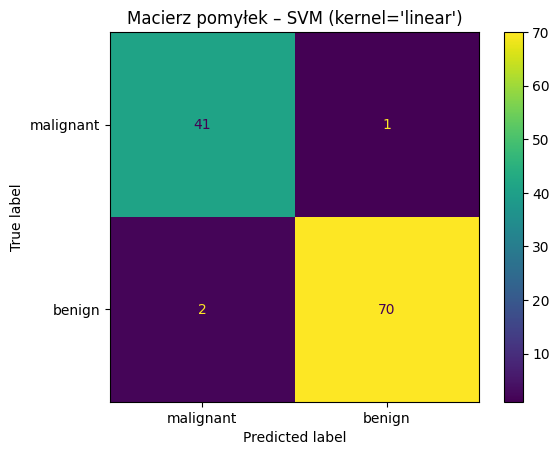

In [11]:
data = load_breast_cancer()
X = data.data     
y = data.target    

print("Kształt X:", X.shape)
print("Liczba klas:", len(data.target_names))
print("Nazwy klas:", data.target_names)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel="linear", C=1.0, random_state=42)
svm_clf.fit(X_train_scaled, y_train)


y_train_pred = svm_clf.predict(X_train_scaled)
y_test_pred = svm_clf.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Dokładność na zbiorze treningowym: {train_acc:.3f}")
print(f"Dokładność na zbiorze testowym:     {test_acc:.3f}")

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)

plt.figure(figsize=(4, 4))
disp.plot(values_format="d")
plt.title("Macierz pomyłek – SVM (kernel='linear')")
plt.show()


- Model SVM z jądrem liniowym osiągnął bardzo dobrą jakość: dokładność na treningu $99.1\%$, na teście $97.4\%$, bez wyraźnych oznak przeuczenia.
- Z macierzy pomyłek: 1 próbka z klasy *malignant* została błędnie zaklasyfikowana jako *benign*, a 2 próbki *benign* jako *malignant*.
- Błąd typu *malignant → benign* jest potencjalnie najbardziej niebezpieczny klinicznie, ale liczba takich przypadków jest minimalna.
- Wysoka skuteczność przy jądrze liniowym sugeruje, że po standaryzacji cech dane są w dużym stopniu liniowo separowalne.


# Zadanie 3

Tworzymy syntetyczny zbiór danych w 2D, który nie jest liniowo separowalny (np. dwa współśrodkowe okręgi).  
Trenujemy dwa modele SVM:

1. z jądrem liniowym (`kernel="linear"`), które szuka granicy postaci $w^\top x + b = 0$,
2. z jądrem RBF (`kernel="rbf"`), które używa funkcji jądra
   $$
   k(x, x') = \exp\big(-\gamma \lVert x - x' \rVert^2\big)
   $$

Dla obu modeli wizualizujemy granice decyzyjne i porównujemy, jak dobrze rozdzielają klasy na tych samych danych.


Dokładność SVM (kernel='linear'): 0.693
Dokładność SVM (kernel='rbf'):    1.000


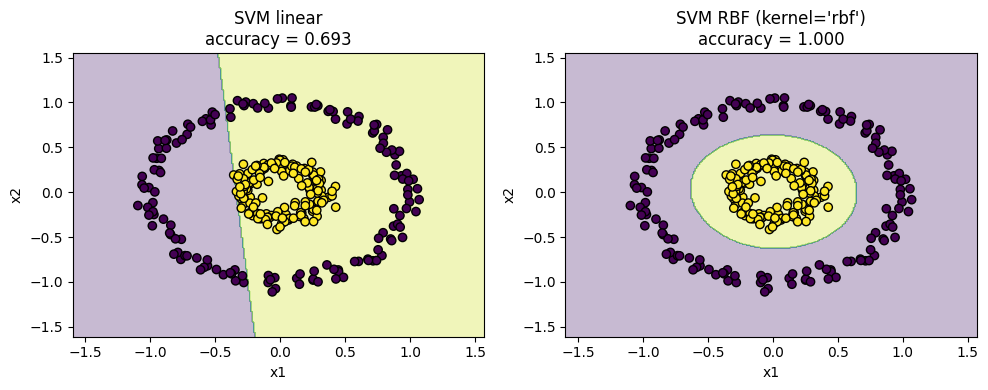

In [12]:
X, y = make_circles(
    n_samples=300,
    factor=0.3,     # stosunek promieni wewnętrznego/zewnętrznego okręgu
    noise=0.05,
    random_state=42
)


svm_linear = SVC(kernel="linear", C=1.0)
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale")

svm_linear.fit(X, y)
svm_rbf.fit(X, y)

y_pred_lin = svm_linear.predict(X)
y_pred_rbf = svm_rbf.predict(X)

acc_lin = accuracy_score(y, y_pred_lin)
acc_rbf = accuracy_score(y, y_pred_rbf)

print(f"Dokładność SVM (kernel='linear'): {acc_lin:.3f}")
print(f"Dokładność SVM (kernel='rbf'):    {acc_rbf:.3f}")


x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]

Z_lin = svm_linear.predict(grid).reshape(xx.shape)
Z_rbf = svm_rbf.predict(grid).reshape(xx.shape)

# granice decyzyjne

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].contourf(xx, yy, Z_lin, alpha=0.3)
scatter0 = axes[0].scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
axes[0].set_title(f"SVM linear\naccuracy = {acc_lin:.3f}")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")

axes[1].contourf(xx, yy, Z_rbf, alpha=0.3)
axes[1].scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
axes[1].set_title(f"SVM RBF (kernel='rbf')\naccuracy = {acc_rbf:.3f}")
axes[1].set_xlabel("x1")
axes[1].set_ylabel("x2")

plt.tight_layout()
plt.show()


- Dane w postaci współśrodkowych okręgów nie są liniowo separowalne w przestrzeni oryginalnych cech, dlatego SVM z jądrem liniowym osiąga tylko ok. $69.3\%$ dokładności i wyznacza prostą granicę decyzyjną.
- SVM z jądrem RBF (`kernel='rbf'`) osiąga $100\%$ dokładności i granica decyzyjna ma kształt okręgów dopasowanych do struktury danych.
- Jądro RBF odpowiada nieliniowemu przekształceniu danych do przestrzeni wyższych wymiarów, gdzie klasy stają się (w przybliżeniu) liniowo separowalne, dlatego w tym zadaniu jest znacznie skuteczniejsze niż jądro liniowe.


# Zadanie 4

Korzystamy ponownie ze zbioru Breast Cancer z `scikit-learn` i modelu SVM z jądrem RBF (`kernel="rbf"`).  
Najpierw trenujemy model z domyślnymi parametrami, a następnie używamy `GridSearchCV`, aby dobrać najlepsze wartości hiperparametrów:

- $C$ – parametr regularyzacji,
- $\gamma$ – parametr szerokości jądra RBF.

Porównujemy dokładność modelu domyślnego i dostrojonego na zbiorze testowym.


In [13]:
data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


base_clf = SVC(kernel="rbf", random_state=42)
base_clf.fit(X_train_scaled, y_train)

y_train_pred_base = base_clf.predict(X_train_scaled)
y_test_pred_base = base_clf.predict(X_test_scaled)

base_train_acc = accuracy_score(y_train, y_train_pred_base)
base_test_acc = accuracy_score(y_test, y_test_pred_base)

print("Model bazowy (SVC, kernel='rbf', domyślne parametry)")
print(f"Dokładność train: {base_train_acc:.3f}")
print(f"Dokładność test:  {base_test_acc:.3f}")
print()

# hiperparametry (GridSearchCV)

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1.0]
}

grid_search = GridSearchCV(
    estimator=SVC(kernel="rbf", random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Najlepsze parametry z GridSearchCV")
print("best_params_:", grid_search.best_params_)
print()

best_clf = grid_search.best_estimator_

y_train_pred_best = best_clf.predict(X_train_scaled)
y_test_pred_best = best_clf.predict(X_test_scaled)

best_train_acc = accuracy_score(y_train, y_train_pred_best)
best_test_acc = accuracy_score(y_test, y_test_pred_best)

print("Model po dostrojeniu hiperparametrów")
print(f"Dokładność train: {best_train_acc:.3f}")
print(f"Dokładność test:  {best_test_acc:.3f}")


Model bazowy (SVC, kernel='rbf', domyślne parametry)
Dokładność train: 0.982
Dokładność test:  0.982

Najlepsze parametry z GridSearchCV
best_params_: {'C': 10, 'gamma': 0.01}

Model po dostrojeniu hiperparametrów
Dokładność train: 0.987
Dokładność test:  0.982


- Model bazowy SVM z jądrem RBF osiąga już bardzo wysoką dokładność: około $98{,}2\%$ na zbiorze treningowym i testowym.
- Po dostrojeniu hiperparametrów ($C = 10$, $\gamma = 0.01$) dokładność na treningu nieznacznie rośnie do $98{,}7\%$, natomiast dokładność na teście pozostaje na poziomie $98{,}2\%$.
- Oznacza to, że strojenie hiperparametrów nie poprawiło zauważalnie uogólniania modelu – domyślne ustawienia były już bliskie optimum, a dalsze zwiększanie $C$ tylko lekko zwiększa dopasowanie do danych treningowych.

# Zadanie 5

Korzystamy znowu ze zbioru Breast Cancer z `scikit-learn` oraz dwóch modeli gradient boosting:

- `XGBClassifier` z biblioteki **xgboost**  
- `LGBMClassifier` z biblioteki **lightgbm**

Dla obu modeli:
1. Dzielimy dane na zbiór treningowy i testowy.  
2. Trenujemy modele na tych samych danych wejściowych.  
3. Mierzymy czas treningu oraz dokładność na zbiorze treningowym i testowym.  


In [62]:
data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

t0 = time.time()
xgb_clf.fit(X_train, y_train)
t_xgb = time.time() - t0

y_train_pred_xgb = xgb_clf.predict(X_train)
y_test_pred_xgb = xgb_clf.predict(X_test)

acc_train_xgb = accuracy_score(y_train, y_train_pred_xgb)
acc_test_xgb = accuracy_score(y_test, y_test_pred_xgb)

print("XGBoost")
print(f"Czas treningu: {t_xgb:.4f} s")
print(f"Dokładność train: {acc_train_xgb:.3f}")
print(f"Dokładność test:  {acc_test_xgb:.3f}")
print()


lgb_clf = LGBMClassifier(
    n_estimators=200,
    max_depth=-1,     
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    objective="binary",
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

t0 = time.time()
lgb_clf.fit(X_train, y_train)
t_lgb = time.time() - t0

y_train_pred_lgb = lgb_clf.predict(X_train)
y_test_pred_lgb = lgb_clf.predict(X_test)

acc_train_lgb = accuracy_score(y_train, y_train_pred_lgb)
acc_test_lgb = accuracy_score(y_test, y_test_pred_lgb)

print("LightGBM ")
print(f"Czas treningu: {t_lgb:.4f} s")
print(f"Dokładność train: {acc_train_lgb:.3f}")
print(f"Dokładność test:  {acc_test_lgb:.3f}")


XGBoost
Czas treningu: 0.0380 s
Dokładność train: 1.000
Dokładność test:  0.947

LightGBM 
Czas treningu: 0.0536 s
Dokładność train: 1.000
Dokładność test:  0.956


c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


- Oba modele (XGBoost i LightGBM) perfekcyjnie dopasowują się do zbioru treningowego.
- Na zbiorze testowym LightGBM uzyskuje nieco lepszą dokładność ($95{,}6\%$) niż XGBoost ($94{,}7\%$), więc minimalnie lepiej generalizuje na tych danych.



- W naszym eksperymencie szybszy okazał się XGBoost: czas treningu $\approx 0{,}038\ \text{s}$ vs $\approx 0{,}054\ \text{s}$ dla LightGBM.
- Różnica wynika głównie z tego, że zbiór Breast Cancer jest mały – narzut związany z implementacją LightGBM (m.in. przygotowanie histogramów) nie zdąża się „zwrócić”.
- Dla małych danych XGBoost może więc wypaść szybciej, natomiast przy dużych, wysokowymiarowych zbiorach to zwykle LightGBM zyskuje przewagę czasową dzięki histogramowemu algorytmowi i efektywnemu wzrostowi drzew.


# Zadanie 6

Korzystamy z modelu `XGBClassifier` na zbiorze Breast Cancer i oceniamy jego jakość za pomocą walidacji krzyżowej `StratifiedKFold`.

Zamiast jednorazowego podziału danych na zbiór treningowy i testowy, dzielimy dane na \(K\) podzbiorów (foldów). Dla każdej iteracji:
- trenujemy model na \(K-1\) foldach,
- testujemy na pozostałym foldzie.

Otrzymujemy \(K\) wyników dokładności i liczymy ich średnią oraz odchylenie standardowe, co daje bardziej stabilną i rzetelną ocenę wydajności modelu niż pojedynczy podział train/test.


In [15]:
data = load_breast_cancer()
X = data.data      
y = data.target    

print("Kształt danych:", X.shape)

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

scores = cross_val_score(
    xgb_clf,
    X,
    y,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

print("Wyniki accuracy w kolejnych foldach:", scores)
print(f"Średnia accuracy: {scores.mean():.3f}")
print(f"Odchylenie standardowe accuracy: {scores.std():.3f}")


Kształt danych: (569, 30)
Wyniki accuracy w kolejnych foldach: [0.98245614 0.93859649 0.95614035 0.97368421 0.95575221]
Średnia accuracy: 0.961
Odchylenie standardowe accuracy: 0.015


- Dla modelu XGBoost średnia dokładność z 5-krotnej walidacji krzyżowej wyniosła około $96{,}1\%$ przy stosunkowo małym odchyleniu standardowym $\approx 0{,}015$. Oznacza to, że model uzyskuje stabilne wyniki na różnych podziałach danych.
- Poszczególne foldy dają accuracy w zakresie mniej więcej $93{,}9\%$–$98{,}2\%$, co pokazuje naturalną zmienność związaną z tym, jak dokładnie podzielimy dane, ale bez drastycznych spadków jakości.
- Walidacja krzyżowa jest lepsza niż jednorazowy podział train/test, ponieważ:
  - wykorzystuje wszystkie próbki zarówno do trenowania, jak i do testowania (w różnych iteracjach),
  - daje średnią po wielu podziałach zamiast pojedynczego, przypadkowego wyniku zależnego od jednego losowego splitu,
  - pozwala oszacować niepewność oceny (odchylenie standardowe), a więc to, jak bardzo wynik zależy od podziału danych.
